# CatBoost incremental learning

Author: https://github.com/deburky

In [1]:
import pyarrow.parquet as pq

# Load dataset metadata:
# ParquetDataset Encapsulates details of reading a complete Parquet dataset
# possibly consisting of multiple files and partitions in subdirectories.

dataset_path = "../data"
dataset = pq.ParquetDataset(dataset_path)
full_df = dataset.read().to_pandas()

## Model API

Run in terminal as:

```bash
uv run app.py
```

In [6]:
import asyncio
import httpx
import nest_asyncio

nest_asyncio.apply()

API_URL = "http://127.0.0.1:8000/predict"

inference_results = {"num_rows": [], "inference_time": []}


async def async_test_inference(num_rows_list):
    async with httpx.AsyncClient() as client:
        tasks = [
            client.post(API_URL, json={"num_rows": num_rows})
            for num_rows in num_rows_list
        ]
        responses = await asyncio.gather(*tasks)

        for response, num_rows in zip(responses, num_rows_list):
            if response.status_code == 200:
                result = response.json()
                inference_results["num_rows"].append(num_rows)
                inference_results["inference_time"].append(result["inference_time"])
                print(
                    f"Success for {num_rows} inference_time: {result['inference_time']}"
                )
            else:
                print(f"Error for {num_rows} inference_time: {response.text}")


# Run async test
asyncio.run(
    async_test_inference(
        [500_000, 1_000_000, 20_000_000, 30_000_000, 40_000_000, 50_000_000]
    )
)

Success for 500000 inference_time: 0.05922662500000797
Success for 1000000 inference_time: 0.06225874999998382
Success for 20000000 inference_time: 0.05742920899999149
Success for 30000000 inference_time: 0.060855083999996396
Success for 40000000 inference_time: 0.0725522500000011
Success for 50000000 inference_time: 0.05697670800000765


Text(0.5, 0, 'Number of rows')

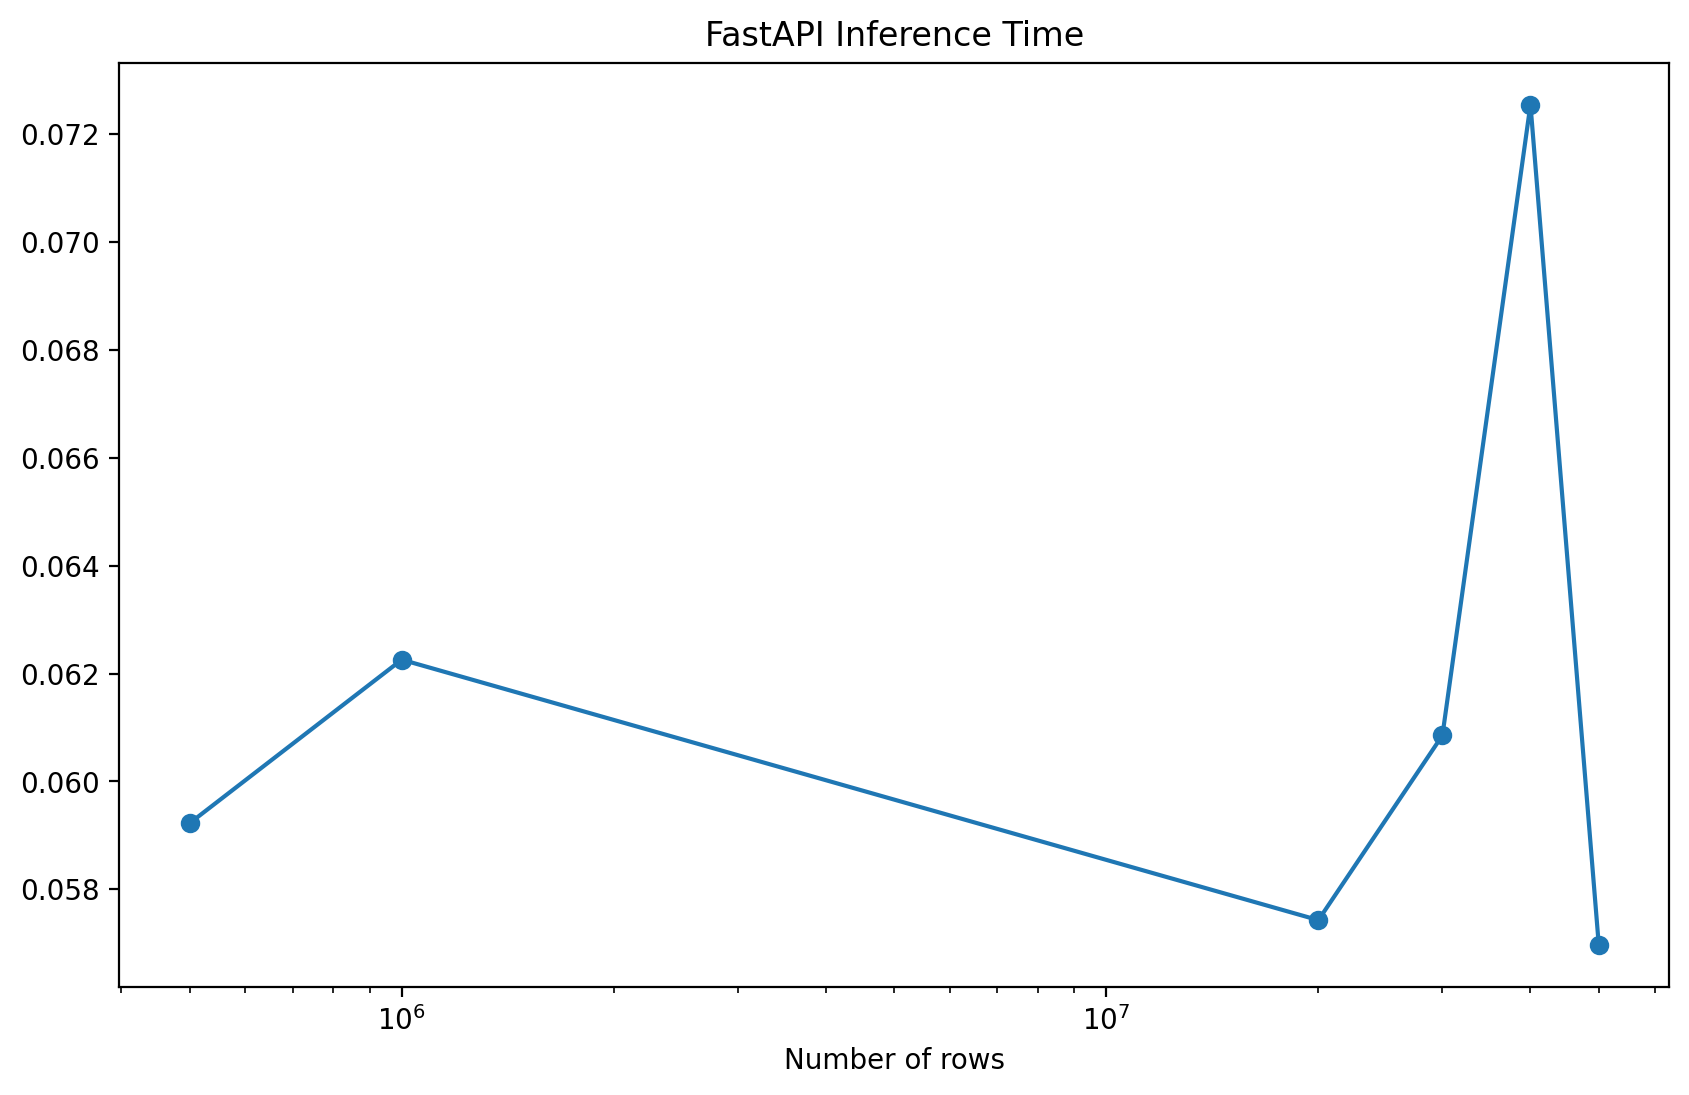

In [7]:
from matplotlib import pyplot as plt

%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots(figsize=(10, 6), facecolor="white")

ax.plot(
    inference_results["num_rows"],
    inference_results["inference_time"],
    marker="o",
    label="FastAPI",
)
ax.set_title("FastAPI Inference Time")
# set x scale to log
ax.set_xscale("log")
ax.set_xlabel("Number of rows")